### Core

In [75]:
# basic python and ML Libraries
import os
import numpy as np
import pandas as pd
from pathlib import Path
# import shutil
import pyautogui
# import time    
# import random
from functools import partial
from collections import deque

# matplotlib & others for visualization
import matplotlib.pyplot as plt
from PIL import Image
import cv2

# torchvision libraries
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary

# misc
from tqdm.notebook import tqdm
from timeit import default_timer as timer

# model
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

device = "cuda" if torch.cuda.is_available() else "cpu"
working_dir = r'C:\Users\earle\PythonMLenv\env'
os.getcwd()

## todo
# train yolov8 eye tracking custom dataset
# data collection (img , (x,y)) segmentation
# model architecture
# debugging and fine tuning 

# info
# 13 x 7 
# 147 x apart 154 y apart


'C:\\Users\\earle\\PythonMLenv\\env'

In [7]:
# functions
def box_xyxy(box: list):
    """[xmin, ymin, xmax, ymax]"""
    x , y = box[0] , box[1]
    w , h = box[2] - box[0] , box[3] - box[1]
    return int(x), int(y), int(w) , int(h)

def get_transform(img):
    train_transform = transforms.Compose([
    transforms.Resize((45,90)),
    transforms.ToTensor(),                       
    ])
    return train_transform(img)

def tensorprint(tensor):
    print("Shape: " , tensor.shape, " , Dimension: ", tensor.ndim , " \nDtype: ", tensor.dtype, " , Device: ", tensor.device)
    print("Max: ", tensor.amax(),f'[{tensor.argmax()}]', " , Min: ", tensor.amin(),f'[{tensor.argmin()}]')
    #print(tensor ,'\n')

def torch_rng():
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    np.random.seed(42)
    

def print_time(start,end,device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

def train_step(model: torch.nn.Module,
                dataloader:torch.utils.data.DataLoader,
                loss_fn:torch.nn.Module,
                optimizer:torch.optim.Optimizer,
                device: torch.device = device):
    """Performs training on dataloader."""
    train_loss = 0
    model.to(device)
    model.train()
    for i, (x,x2,y) in enumerate(dataloader):
        
        x, x2, y = x.to(device), x2.to(device), y.to(device)
        y_pred = model(x,x2)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print(f"current Loss: {train_loss}")

    train_loss /= len(dataloader)
    #print(f"\nTrain loss: {train_loss:.4f}")
    return train_loss

def test_step(model: torch.nn.Module,
                dataloader:torch.utils.data.DataLoader,
                loss_fn:torch.nn.Module,
                device: torch.device = device):
    """Performs testing on dataloader."""
    test_loss = 0
    model.to(device)
    model.eval()

    with torch.inference_mode():
        for i, (x,x2,y) in enumerate(dataloader):

            x, x2, y = x.to(device), x2.to(device), y.to(device)
            test_pred = model(x,x2)
            test_loss += loss_fn(test_pred,y).item()
            #print(f"current Loss: {test_loss}")

        test_loss /= len(dataloader)

    #print(f"\nTest loss: {test_loss:.4f}")
    return test_loss

def train(model: torch.nn.Module,
            train_dataloader:torch.utils.data.DataLoader,
            test_dataloader:torch.utils.data.DataLoader,
            optimizer:torch.optim.Optimizer,
            loss_fn:torch.nn.Module,
            epochs: int = 5,
            device = device):
    """Combines train_step and test_step function"""
    results = {"train_loss" : [],
                "test_loss" : [],
                }
    for epoch in tqdm(range(epochs)):
        train_loss  = train_step(model,
                                dataloader=train_dataloader,
                                loss_fn=loss_fn,
                                optimizer=optimizer,
                                device=device)
        test_loss  = test_step(model,
                                dataloader=test_dataloader,
                                loss_fn=loss_fn,
                                device=device)
        print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Test loss: {test_loss:.4f}")
        results["train_loss"].append(train_loss)
        results["test_loss"].append(test_loss)
    return results

def plot_loss_curves(results):
    """Plots training curves of result dictionary."""
    loss = results["train_loss"]
    test_loss = results["test_loss"]
    epochs = range(len(results["train_loss"]))

    plt.figure(figsize = (15,7))
    plt.subplot(1,2,1)
    plt.plot(epochs,loss,label = "train_loss")
    plt.plot(epochs,test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()



### YOLOv5 data collection

In [ ]:
# # collecting custom data for yolo
# fp = r'C:\Users\earle\PythonMLenv\env\projects\data\Eye_tracker\\'
# root = r'C:\Users\earle\PythonMLenv\env\projects\data\Eye_tracker\Eye_tracker'
# images_p = r'C:\Users\earle\PythonMLenv\env\projects\data\Eye_tracker\images'
# labels_p = r'C:\Users\earle\PythonMLenv\env\projects\data\Eye_tracker\labels'
# train_images = root + '\\images\\train'
# train_label = root + '\\label\\train'
# val_image = root + '\\images\\val'
# val_label = root + '\\labels\\val'

# # frames_fp = fp + 'frames'
# # current_frame = 0
# # cam = cv2.VideoCapture(fp + 'WIN_20230214_10_09_27_Pro.mp4')
# # while(True):
# #     ret, frame = cam.read()
# #     if ret:
# #         name = frames_fp + str(current_frame) + '.jpg'
# #         cv2.imwrite(name, frame)
# #         current_frame +=1
# #     else:
# #         break
# # cam.release()
# # cv2.destroyAllWindows()

# fp_img = os.listdir(fp + 'images')
# fp_label = os.listdir(fp + 'labels')
# fp_img_sp = [i[:-4] for i in fp_img]
# fp_label_sp = [i[:-4] for i in fp_label]
# fp_sp = []
# for i in fp_img_sp:
#     if i in fp_label_sp:
#         fp_sp.append(i)

# fp_img = [i + '.jpg' for i in fp_sp]
# fp_label = [i + '.txt' for i in fp_sp]
# fp_val = [i for i in fp_sp[-18:]]

# # for i in range(len(fp_img) - 18):
# #     shutil.copy(images_p + '\\' + fp_val[i] + '.jpg', val_image)
# #     shutil.copy(labels_p + '\\' + fp_val[i] + '.txt', val_label)

In [ ]:
# train custom data for yolo
# os.chdir(r'C:\Users\earle\PythonMLenv\env\yolov5')
% python train.py --img 640 --batch 2 --epochs 600 --data eye_tracker.yaml --weights yolov5s.pt --device 0 --workers 1 --patience 300

In [ ]:
# inference
# best model exp12 then exp 13 , 14

% runs\train\exp4\weights\best.pt
% C:\\Users\\earle\\PythonMLenv\\env\\projects\\data\\Custom
%  python detect.py --weights runs\\train\\exp12\\weights\\best.pt --source 0 --data eye_tracker.yaml --img 640 --iou-thres 0.6 --conf-thres 0.6 

In [ ]:
# # model for eye tracking
# os.chdir(working_dir)
# model = torch.hub.load('yolov5','custom', path='yolov5/runs/train/exp12/weights/best.pt', source='local', device = 0)
# # model.conf = 0.25
# # model.max_det = 2
# # model.to(device)

# #t = r'C:\\Users\\earle\\PythonMLenv\\env\\projects\\data\\Custom\\frames10.jpg'
# # model(t).pandas().xyxy[0]

In [ ]:
# le_image_path = r'C:\Users\earle\PythonMLenv\env\projects\data\Eye_tracker\cords_model\images\left'
# re_image_path = r'C:\Users\earle\PythonMLenv\env\projects\data\Eye_tracker\cords_model\images\right'
# label_path = r'C:\Users\earle\PythonMLenv\env\projects\data\Eye_tracker\cords_model\labels\\'

# x = 70
# y = 105
# frame = 225

# def get_data_eyetracking():
#     global frame
    
#     cam = cv2.VideoCapture(0)
#     result, image = cam.read()
#     img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     if result:

#         image_cv = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         im_pil = Image.fromarray(image_cv)
#         res = model(im_pil, size = 640)
#         if len(res.xyxy[0]) == 2:
#             df = res.pandas().xyxy[0]

#             if len(df.loc[df['name'] == 'left eye']) == 1 and len(df.loc[df['name'] == 'right eye']) == 1:
#                 le = df.loc[df['class'] == 0]
#                 re = df.loc[df['class'] == 1]
#                 le_xmin , le_ymin , le_xmax, le_ymax = le['xmin'], le['ymin'] , le['xmax'], le['ymax']
#                 re_xmin , re_ymin , re_xmax, re_ymax = re['xmin'], re['ymin'] , re['xmax'], re['ymax']
#                 box1 = [le_xmin, le_ymin, le_xmax, le_ymax]
#                 box2 = [re_xmin, re_ymin, re_xmax, re_ymax]
#                 X, Y, W, H = box_xyxy(box1)
#                 X2, Y2, W2, H2 = box_xyxy(box2)
#                 img1 = img_gray[Y:Y+H, X:X+W]
#                 img2 = img_gray[Y2:Y2+H2, X2:X2+W2]
#                 cv2.imwrite(os.path.join(le_image_path, str(frame) + '_l.jpg'), img1)
#                 cv2.imwrite(os.path.join(re_image_path, str(frame) + '_r.jpg'), img2)
#                 cv2.waitKey(0)
#                 text = str(x) + ' ' + str(y)
#                 filename = str(frame) + '.txt'
#                 with open(label_path + filename, "w+") as f:
#                     f.write(text)
#                     f.close()

#                 frame +=1

# # pyautogui.moveTo(x,y)
# # for i in range(7):
# #     pyautogui.moveTo(x,y)
# #     get_data_eyetracking()
# #     get_data_eyetracking()
# #     get_data_eyetracking()
# #     get_data_eyetracking()
# #     get_data_eyetracking()
# #     time.sleep(1)
    
# #     for i in range(6):
# #         y += 154
# #         pyautogui.moveTo(x,y)
# #         get_data_eyetracking()
# #         get_data_eyetracking()
# #         get_data_eyetracking()
# #         get_data_eyetracking()
# #         get_data_eyetracking()
# #         time.sleep(1)
# #         if i == 5:
# #             y = 105
    
# #     x += 147

In [ ]:
# # t = r'C:\\Users\\earle\\PythonMLenv\\env\\projects\\data\\Custom\\frames10.jpg'

# cam = cv2.VideoCapture(0)
# result, image = cam.read()
# model.conf = 0.25
# res = model(image , size= 640)
# crops = res.crop(save=False)
# crops

In [ ]:
# imgtest = crops[1]['im']
# imgtest = Image.fromarray(imgtest).convert('L')
# imgtest = imgtest.resize((90,45), Image.LANCZOS)
# imgtest

### Datasets and Dataloader

In [8]:
# dataset 

left = r'C:\Users\earle\PythonMLenv\env\projects\data\Eye_tracker\cords_model\images\left'
right = r'C:\Users\earle\PythonMLenv\env\projects\data\Eye_tracker\cords_model\images\right'
label_path = r'C:\Users\earle\PythonMLenv\env\projects\data\Eye_tracker\cords_model\labels\\'
left_test = r'C:\Users\earle\PythonMLenv\env\projects\data\Eye_tracker\cords_model\images\left_test'
right_test =r'C:\Users\earle\PythonMLenv\env\projects\data\Eye_tracker\cords_model\images\right_test'
label_test = r'C:\Users\earle\PythonMLenv\env\projects\data\Eye_tracker\cords_model\labels_test'

class EyeDataset(Dataset):
    def __init__(self, image, image2,label , transforms) -> None:
        self.image = image
        self.image2 = image2
        self.label = label
        self.transforms = transforms

        self.imgs = os.listdir(image)
        self.imgs2 = os.listdir(image2)
        self.labels = os.listdir(label)

        self.imgs = [i for i in self.imgs]
        self.imgs2 = [i for i in self.imgs2]
        self.labels_name_list = [i for i in self.labels]
        self.imgs.sort()
        self.labels_name_list.sort()

    def __getitem__(self, idx):
        img_path = os.path.join(self.image , self.imgs[idx])
        img_path2 = os.path.join(self.image2 , self.imgs2[idx])
        lbl_path = os.path.join(self.label , self.labels_name_list[idx])
        with open(lbl_path, 'r') as f:
            for l in f:
                sp = l.split()
            label = [int(i) for i in sp]
        
        img = Image.open(img_path).convert('L')
        img2 = Image.open(img_path2).convert('L')

        cords = torch.as_tensor(label, dtype=torch.float32)
        target = {}

        target['cords'] = cords
        target['left_img'] = img
        target['right_img'] = img2

        if self.transforms:
            target['left_img'] = self.transforms(target['left_img'])
            target['right_img'] = self.transforms(target['right_img'])
        
        return target['left_img'] , target['right_img'] , target['cords']

    def __len__(self):
        return len(self.labels)
        
# e = EyeDataset(left, right,label_path, get_transform)
# e[0]


In [9]:
# dataloading
BATCH_SIZE = 16
train_data = EyeDataset(left, right, label_path, get_transform)  
test_data = EyeDataset(left_test, right_test, label_test, get_transform)

train_dataloader = DataLoader(dataset=train_data, 
                                batch_size=BATCH_SIZE,
                                shuffle=True,
                                )
test_dataloader = DataLoader(dataset=test_data,
                                batch_size=BATCH_SIZE,
                                shuffle=False)

img, img2, target = next(iter(train_dataloader))
testimg, testimg2, target2 = next(iter(test_dataloader))
images = list(image.to(device) for image in img)
images2 = list(image.to(device) for image in img2)
images2[0].unsqueeze(0).shape


torch.Size([1, 1, 45, 90])

### Training model 

In [16]:
# model
class ConvNetModel(nn.Module):
    def __init__(self, hidden) -> None:
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=1,
                        out_channels=hidden,
                        kernel_size=3,
                        stride=1,
                        padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(hidden),
            nn.MaxPool2d(kernel_size=2,
                            stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(hidden*2*21*44, hidden),
            nn.Linear(hidden,hidden),
            nn.Linear(hidden, 2),
        )

    def forward(self, x, x2):
        #print(x.shape)
        x = self.conv_block_1(x)
        x2 = self.conv_block_1(x2)
        out = torch.cat((x,x2), dim=1)
        #print(out.shape)
        x = self.classifier(out)
        #print(x.shape)
        return x 

model_9 = ConvNetModel(
    hidden= 64,
).to(device)
with torch.inference_mode():
    pred_wt = model_9(images[0].unsqueeze(0), images2[0].unsqueeze(0))
pred_wt

tensor([[-0.0617, -0.0509]], device='cuda:0')

In [17]:
# train
lossfn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params = model_9.parameters(), lr = 0.00020684642767261895)
torch_rng()
start = timer()
model_9_result= train(model_9, train_dataloader,test_dataloader, optimizer,lossfn, epochs=60) 
end = timer()
print_time(start,end, device)
model_9_result

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 116682.4195 | Test loss: 35718.6092
Epoch: 1 | Train Loss: 13690.8192 | Test loss: 12787.7484
Epoch: 2 | Train Loss: 7154.4456 | Test loss: 11080.9556
Epoch: 3 | Train Loss: 4952.6599 | Test loss: 6679.0628
Epoch: 4 | Train Loss: 4108.9660 | Test loss: 5798.1819
Epoch: 5 | Train Loss: 3220.2366 | Test loss: 5724.0693
Epoch: 6 | Train Loss: 2643.7963 | Test loss: 4425.0124
Epoch: 7 | Train Loss: 2272.8476 | Test loss: 4068.7134
Epoch: 8 | Train Loss: 1896.1996 | Test loss: 4631.3460
Epoch: 9 | Train Loss: 1778.4538 | Test loss: 4739.1379
Epoch: 10 | Train Loss: 1781.9300 | Test loss: 3309.1128
Epoch: 11 | Train Loss: 1393.8073 | Test loss: 4186.7365
Epoch: 12 | Train Loss: 1318.8146 | Test loss: 3176.5253
Epoch: 13 | Train Loss: 1012.6546 | Test loss: 3279.8768
Epoch: 14 | Train Loss: 1076.1577 | Test loss: 3073.9012
Epoch: 15 | Train Loss: 942.4226 | Test loss: 3602.5877
Epoch: 16 | Train Loss: 829.0537 | Test loss: 3781.1980
Epoch: 17 | Train Loss: 752.1209 | Te

{'train_loss': [116682.41953499608,
  13690.819228722305,
  7154.445621873967,
  4952.659858098105,
  4108.965999542721,
  3220.236562416036,
  2643.7962500758904,
  2272.8476170635727,
  1896.1996213317548,
  1778.4537506103516,
  1781.9299532370592,
  1393.8072512994997,
  1318.8145982853318,
  1012.6545752066153,
  1076.1577261364648,
  942.4225858052572,
  829.0537240568292,
  752.1209100692992,
  705.1255415154512,
  791.6714318896097,
  875.4952942580774,
  704.5016136674024,
  711.268026240919,
  604.0064836734186,
  617.8347078050886,
  581.4329381064763,
  761.3950743902298,
  598.9594696690797,
  790.9566132883547,
  714.8460602533249,
  871.7863987413033,
  641.2187588404096,
  669.8859187534878,
  908.6296428347391,
  883.109989933236,
  482.24308417587685,
  524.7290237568043,
  548.5348844074067,
  635.0164422131089,
  560.9982500530425,
  552.8378664097457,
  462.6145029168911,
  529.5536904965759,
  526.3793360367023,
  543.1820869445801,
  605.7018907940577,
  563.8383

Test Pixel error: 51.62
Train Pixel error: 21.78


,train_loss,test_loss
55,451.384853,2883.248505
56,440.898645,2902.733479
57,363.753068,2815.302850
58,474.248080,2664.580017
59,614.838777,3633.947747


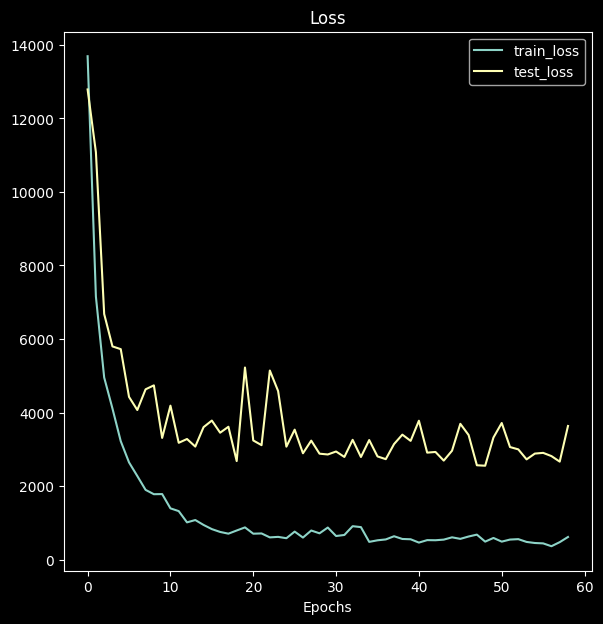

In [25]:
# plot Overall
df = pd.DataFrame(model_9_result)
plot_loss_curves(df[-59:])
print(f"Test Pixel error: {round(np.sqrt(model_9_result['test_loss'][58]),2)}")
print(f"Train Pixel error: {round(np.sqrt(model_9_result['train_loss'][58]),2)}")
df.tail()

### Predicting

In [31]:
model = torch.hub.load('yolov5','custom', path='yolov5/runs/train/exp12/weights/best.pt', source='local', device = 0)
model.conf = 0.25
model.max_det = 2
model.to(device)

YOLOv5  v7.0-80-gc3c8e71 Python-3.10.6 torch-1.13.1+cu116 CUDA:0 (NVIDIA GeForce GTX 1060 6GB, 6144MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  

In [144]:
# test_le = r'C:\Users\earle\PythonMLenv\env\projects\data\Eye_tracker\cords_model\images\left\0.jpg'
# test_re = r'C:\Users\earle\PythonMLenv\env\projects\data\Eye_tracker\cords_model\images\right\0.jpg'
# x , y = 952 , 105

cam = cv2.VideoCapture(0)
result, image = cam.read()
res = model(image , size= 640)
crops = res.crop(save=False)

In [146]:
# predicting
model_9.eval()
cam = cv2.VideoCapture(0)

while True:
    result, image = cam.read()
    res = model(image , size= 640)
    crops = res.crop(save=False)
    if len(crops) > 1:
        img_right = Image.fromarray(crops[0]['im']).convert('L')
        img_left = Image.fromarray(crops[1]['im']).convert("L")

        test_le = get_transform(img_left).to(device).unsqueeze(0)
        test_re = get_transform(img_right).to(device).unsqueeze(0)

        with torch.inference_mode():
            x, y = model_9(test_le, test_re).tolist()[0]
            pyautogui.moveTo()
            

KeyboardInterrupt: 

In [95]:
# track_x = deque([0] * 5, 5)
# track_y = deque([0] * 5, 5)
# track_x.append(x)
# track_y.append(y)
# weights = np.arange(1, 6)
# x = np.average(track_x, weights=weights)
# y = np.average(track_y, weights=weights)
# pyautogui.moveTo(x, y)

### Hyperparameter Tuning

In [5]:
# hyperparameter tuning
checkpoint_dir = r'C:\Users\earle\PythonMLenv\env\projects\Models\checkpoint'

def trainParameter(config):
    torch_rng()
    model = ConvNetModel(hidden = config['hidden'])
    lossfn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(params = model.parameters(), lr = config["lr"])
    
    train_data = EyeDataset(left, right, label_path, get_transform)  
    test_data = EyeDataset(left_test, right_test, label_test, get_transform)

    train_dataloader = DataLoader(dataset=train_data, 
                                    batch_size=config['batch_size'],
                                    shuffle=True,
                                    )
    test_dataloader = DataLoader(dataset=test_data,
                                    batch_size=config['batch_size'],
                                    shuffle=False)

    train_loss = 0
    model.to(device)
    model.train()
    for epoch in tqdm(range(config["epochs"])):
        
        for i, (x,x2,y) in enumerate(train_dataloader):
            x, x2, y = x.to(device), x2.to(device), y.to(device)
            y_pred = model(x,x2)
            loss = lossfn(y_pred, y)
            train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss /= len(train_dataloader)
        test_loss = 0
        model.eval()
        with torch.inference_mode():
            for i, (x,x2,y) in enumerate(test_dataloader):
            
                x, x2, y = x.to(device), x2.to(device), y.to(device)
                test_pred = model(x,x2)
                test_loss += lossfn(test_pred,y).item()

        test_loss /= len(test_data)
        tune.report(loss = test_loss)
        #print(f"Train Loss: {train_loss} | Test Loss: {test_loss}")

config = {
    "hidden" : tune.choice([4,8,16,32,64,128]),
    "lr"     : tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([2,4,8,16,32]),
    "epochs" : tune.choice([60, 120, 180, 240, 320])
}

analysis =  tune.run(
    trainParameter,
    config= config,
    num_samples=1,
    metric= "loss",
    mode= "min",
)

print("Best Hyperparameters: ", analysis.best_config)
    

2023-02-17 11:31:45,306	INFO tune.py:762 -- Total run time: 590.67 seconds (590.45 seconds for the tuning loop).


Best Hyperparameters:  {'hidden': 64, 'lr': 0.010883709163376687, 'batch_size': 2, 'epochs': 180}


In [ ]:
# parameters

# 2/16/2023 
# lr = 0.00020684642767261895
# hidden = 64
# BATCH_SIZE = 16
# epoch = 60

# 2/17/2023
# Best Hyperparameters:  {'hidden': 64, 
#                         'lr': 0.010883709163376687, 
#                         'batch_size': 2, 
#                         'epochs': 180}


### Saving , loading and Inference

In [27]:
# Save
# MODEL_PATH.mkdir(parents= True, exist_ok =True)
MODEL_PATH = Path("Models")
MODEL_NAME = "eye_tracker_3.pt"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
path_rel = r'C:\Users\earle\PythonMLenv\env\projects\Models\eye_tracker_3.pt'
# torch.save(model_9.state_dict(), MODEL_SAVE_PATH)
# model_9.load_state_dict(torch.load(path_rel))
# model_9.eval()
